![Py4Eng](img/logo.png)

# Feed Forward Network with Keras
## Yoav Ram

In this session we will understand:
- what is Keras
- how to use Keras to construct and train a feed forward networks
- how to save trained models and then load them to re-train or predict with them

# Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) (MS deep learning package), or [Theano](http://www.deeplearning.net/software/theano/).

The main benefit is that it *allows for easy and fast prototyping*.

Since version 1.4 of TensorFlow, Keras is installed with TensorFlow as a high-level interface to TensorFlow.

# TensorFlow

[TensorFlow™](https://www.tensorflow.org/) is an **open source** software library for **numerical computation** using **data flow graphs**. **Nodes** in the graph represent **mathematical operations**, while the graph **edges** represent the multidimensional **data arrays** (tensors) communicated between them. 

The flexible architecture allows you to **deploy** computation to one or more **CPUs** or **GPUs** in a **desktop, server, mobile device, or cluster**, with a single API. 

TensorFlow is developed by researchers and engineers working on the **Google Brain Team** within **Google's Machine Intelligence research organization** for the purposes of conducting **machine learning and deep neural networks research**, but the system is general enough to be applicable in a wide variety of other domains as well.

TensorFlow is installed with Anaconda.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras

print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

Keras 2.3.1
GPU: False



Using TensorFlow backend.


# Classifiying images

Let's use Keras for the [softmax](softmax-model.ipynb) and [FFN](FFN.ipynb) models we developed previously.

We use Keras' datasets module to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [3]:
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels:

In [20]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

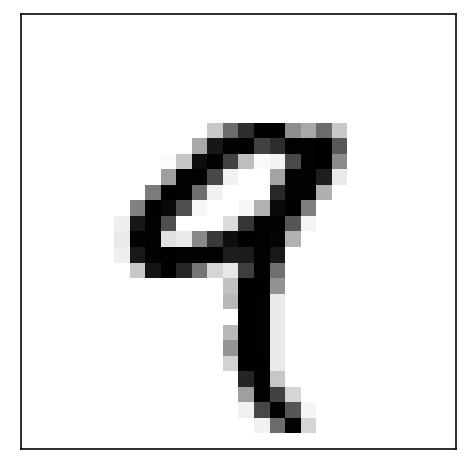

In [21]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[4])

# Softmax model

A Keras model can be built by defining the model layers, then giving them to the `Sequential` model object.
You could also first create the model object and the use its `add` method to add layers.

A `Dense` layer uses matrix muliplication. We need to provide it with the number of outputs, in this case the number of categories, and the activation function, in this case the softmax function.

A `Flatten` layer just flatten the input data - turns it into a 1D array.
The first layer always has to be told the shape of the input (`X`).

In [22]:
layers = [
    keras.layers.Flatten(input_shape=(width, height)),
    keras.layers.Dense(ncats, activation='softmax')
]
model = keras.models.Sequential(layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Next, we need to compile the Keras model, configuring it for training.

In [23]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='sgd',
    metrics=['accuracy']
)

Finally, we can train or fit the model. 

In [15]:
history = model.fit(
    X_train, Y_train,
    batch_size=50,
    epochs=30,
    validation_data=(X_test, Y_test)
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================]60000/60000 [==============================] - 2s 31us/step - loss: 0.9175 - acc: 0.7856 - val_loss: 0.5561 - val_acc: 0.8697

Epoch 2/30
60000/60000 [==============================]60000/60000 [==============================] - 2s 26us/step - loss: 0.5173 - acc: 0.8705 - val_loss: 0.4488 - val_acc: 0.8868

Epoch 3/30
60000/60000 [==============================]60000/60000 [==============================] - 2s 27us/step - loss: 0.4473 - acc: 0.8832 - val_loss: 0.4049 - val_acc: 0.8959

Epoch 4/30
60000/60000 [==============================]60000/60000 [==============================] - 2s 27us/step - loss: 0.4128 - acc: 0.8903 - val_loss: 0.3802 - val_acc: 0.9010

Epoch 5/30
60000/60000 [==============================]60000/60000 [==============================] - 2s 27us/step - loss: 0.3913 - acc: 0.8944 - val_loss: 0.3637 - val_acc: 0.9038

Epoch 6/30
60000/60000 [================

Save the model and the training history:

In [16]:
model.save('../data/keras_ffn_model.h5')
with open("../data/keras_ffn_history.p", "wb") as f:
    pickle.dump(history, f)

Load the model and the history:

In [25]:
model = keras.models.load_model('../data/keras_ffn_model.h5')
with open("../data/keras_ffn_history.p", "rb") as f:
    history = pickle.load(f)

Plot the history:

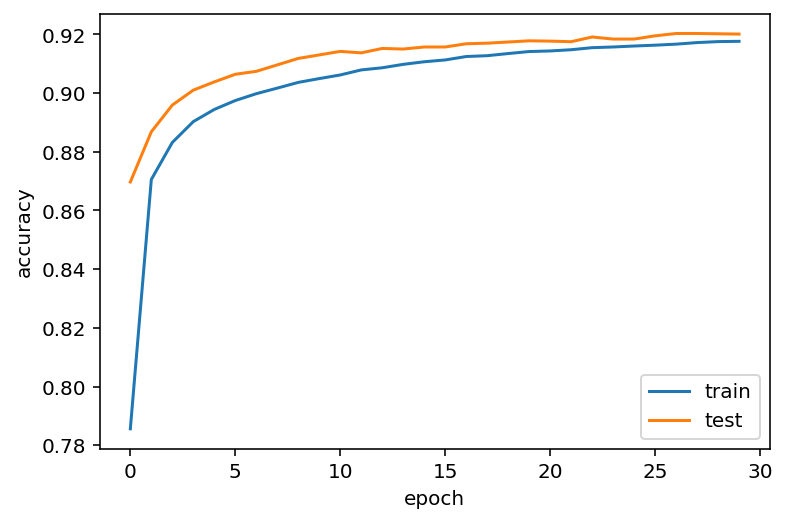

In [26]:
def plot_history(history):
    plt.plot(history['acc'], label='train')
    plt.plot(history['val_acc'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

plot_history(history)

# Exercise: Feed forward with one hidden layer

Let's add a hidden layer so that we have:
$$
\mathbf{H} = ReLU(\mathbf{X} \cdot \mathbf{W_1} + b_1) \\
\mathbf{\widehat Y} = softmax(\mathbf{H} \cdot \mathbf{W_2} + b_2) \\
$$
Create a new model, with an additional hidden layer, compile it, and fit it.
Use the Adam optimizer instead of Stochastic Gradient Descent.

Then save the history and the model to `../data/keras_ffn2_history.p` and `../data/keras_ffn2_model.h5`.

A solution is given in `../solutions/K_FFN.py`.

In [7]:
model = keras.models.load_model('../data/keras_ffn2_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


Finall test accuracy 0.9769


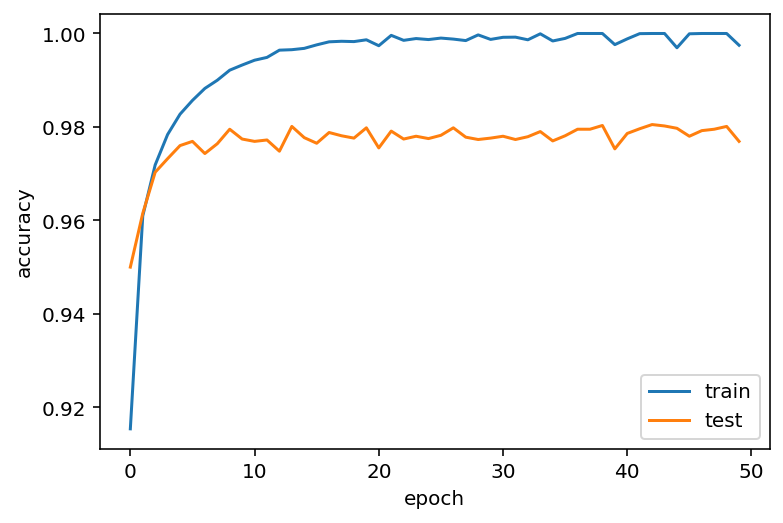

In [12]:
with open("../data/keras_ffn2_history.p", "rb") as f:
    history = pickle.load(f)
plot_history(history)
print("Finall test accuracy {:.4f}".format(history['val_acc'][-1]))

# Convolutional neural network

A convolutional neural networks replaces the density layers with convolutional layers that can efficiently extract local features from structured data such as images, audio, and digital signals. See [Stanford's CS231n](https://cs231n.github.io/convolutional-networks/) for a brief introduction and [Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville](http://www.deeplearningbook.org), ch. 9, for a comprehensive introduction.

We can easily implement convolutional networks, as well as many other networks, with Keras.

In [27]:
layers = [
    keras.layers.Reshape((width, height, 1), input_shape=(width, height)),
    keras.layers.Conv2D(32, (5, 5), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
]
model = keras.models.Sequential(layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
__________

In [28]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    X_train, Y_train,
    batch_size=50,
    epochs=5,
    verbose=1,
    validation_data=(X_test, Y_test)
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================]60000/60000 [==============================] - 40s 671us/step - loss: 0.2198 - acc: 0.9324 - val_loss: 0.0388 - val_acc: 0.9876

Epoch 2/5
60000/60000 [==============================]60000/60000 [==============================] - 41s 683us/step - loss: 0.0692 - acc: 0.9799 - val_loss: 0.0334 - val_acc: 0.9892

Epoch 3/5
60000/60000 [==============================]60000/60000 [==============================] - 38s 637us/step - loss: 0.0504 - acc: 0.9855 - val_loss: 0.0259 - val_acc: 0.9913

Epoch 4/5
60000/60000 [==============================]60000/60000 [==============================] - 42s 705us/step - loss: 0.0411 - acc: 0.9881 - val_loss: 0.0314 - val_acc: 0.9899

Epoch 5/5
60000/60000 [==============================]60000/60000 [==============================] - 42s 702us/step - loss: 0.0354 - acc: 0.9898 - val_loss: 0.0255 - val_acc: 0.9907



Note that we get (slightly) better results than the single-hidden-layer FFN (99% vs 98% accuracy) at the cost of adding ~52,000 parameters to a model that already had ~100,000 parameters.

In [40]:
model.save('../data/keras_cnn_model.h5')

In [30]:
model = keras.models.load_model('../data/keras_cnn_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               102500    
__________

Finall test accuracy 0.9934


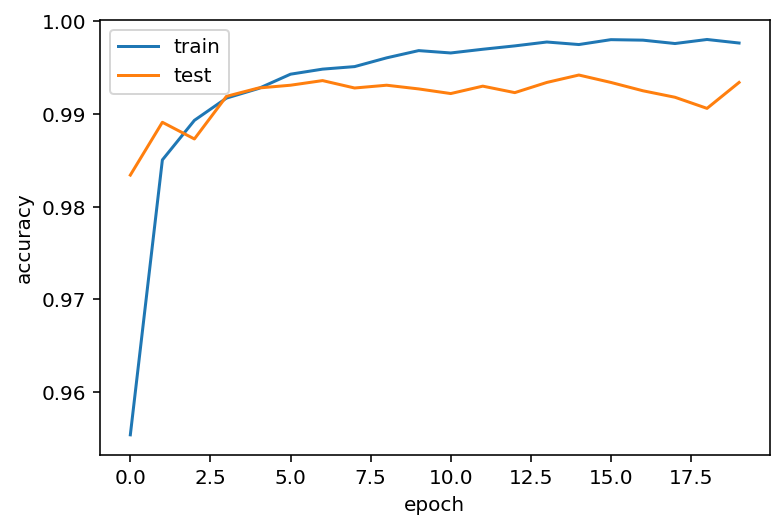

In [31]:
with open("../data/keras_cnn_history.p", "rb") as f:
    history = pickle.load(f)
plot_history(history)
print("Finall test accuracy {:.4f}".format(history['val_acc'][-1]))

# Exercise

Use a feed forward or convolutional network to classify images in the [Fashion-MNIST](../exercises/CNN.ipynb) dataset.

# References

- Keras [docs](https://keras.io)
- See the [Keras examples library](https://github.com/keras-team/keras/tree/master/examples)
- Visualize the network weights using Quiver.
- [TensorFlow](http://tensorflow.org)'s website has tutorials

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)